In [2]:
import json
import pandas as pd
import numpy as np
import os
import math

FIELD_LENGTH = 105.0  # unit: meters
FIELD_WIDTH = 68.0  # unit: meters
GOAL_WIDTH = 7.32  # unit: meters
PENALTY_X = 105.0/2-16.5 # left point (unit: meters)
PENALTY_Y = 40.32 # upper point (unit: meters)

statsbomb_match_id = 3894907
statsbomb_event_path = "/home/z_chen/workspace3/laliga/laliga_23/statsbomb/events/3894907.csv"
skillcorner_tracking_path = "/home/z_chen/workspace3/laliga/laliga_23/skillcorner_v2/tracking/1553748.json"
skillcorner_match_path = "/home/z_chen/workspace3/laliga/laliga_23/skillcorner_v2/match/1553748.json"


if not os.path.exists(statsbomb_event_path):
    raise FileNotFoundError(f"Statsbomb event file not found: {statsbomb_event_path}")
if not os.path.exists(skillcorner_tracking_path):
    raise FileNotFoundError(f"Skillcorner tracking file not found: {skillcorner_tracking_path}")
if not os.path.exists(skillcorner_match_path):
    raise FileNotFoundError(f"Skillcorner match file not found: {skillcorner_match_path}")

# load data
events = pd.read_csv(statsbomb_event_path)

with open(skillcorner_tracking_path) as f:
    tracking = json.load(f)

with open(skillcorner_match_path, encoding='utf-8') as f:
    match = json.load(f)

team_name_dict = {
    'UD Almería': 'Almería', 'Real Sociedad': 'Real Sociedad', 'Athletic Club de Bilbao': 'Athletic Club', 
    'Villarreal CF': 'Villarreal', 'RC Celta de Vigo': 'Celta Vigo', 'Getafe CF': 'Getafe', 
    'UD Las Palmas': 'Las Palmas', 'Sevilla FC': 'Sevilla', 'Cadiz CF': 'Cádiz', 
    'Atlético Madrid': 'Atlético Madrid', 'RCD Mallorca': 'Mallorca', 'Valencia CF': 'Valencia', 
    'CA Osasuna': 'Osasuna', 'Girona FC': 'Girona', 'Real Betis Balompié': 'Real Betis', 
    'FC Barcelona': 'Barcelona', 'Deportivo Alavés': 'Deportivo Alavés', 'Granada CF': 'Granada', 
    'Rayo Vallecano': 'Rayo Vallecano', 'Real Madrid CF': 'Real Madrid'
}

home_team_name = team_name_dict[match['home_team']['name']]
away_team_name = team_name_dict[match['away_team']['name']]

team_dict = {
    match['home_team']['id']: {'role': 'home', 'name': home_team_name},
    match['away_team']['id']: {'role': 'away', 'name': away_team_name}
}

def rotate_around_center(x, y, center_x=105/2, center_y=34):

    translated_x = x - center_x
    translated_y = y - center_y

    rotated_x = -translated_x
    rotated_y = -translated_y

    new_x = rotated_x + center_x
    new_y = rotated_y + center_y

    return new_x, new_y

# trackable_objects
trackable_objects = {}
home_count = away_count = 0
home_id_mapping = {}
away_id_mapping = {}
for player in match['players']:
    role = team_dict[player['team_id']]['role']
    position = player['player_role']['name']
    if role == 'home':
        home_id_mapping[home_count] = len(home_id_mapping) + 1 
        trackable_objects[player['trackable_object']] = {
            'name': f"{player['first_name']} {player['last_name']}".strip(),
            'team': team_dict[player['team_id']]['name'],
            'role': role,
            'id': home_count,
            'position': position
        }
        home_count += 1
    elif role == 'away':
        away_id_mapping[away_count] = len(away_id_mapping) + 1 
        trackable_objects[player['trackable_object']] = {
            'name': f"{player['first_name']} {player['last_name']}".strip(),
            'team': team_dict[player['team_id']]['name'],
            'role': role,
            'id': away_count,
            'position': position
        }
        away_count += 1

trackable_objects[match['ball']['trackable_object']] = {'name': 'ball', 'team': 'ball', 'role': 'ball', 'position': 'ball'}
ball_id = match['ball']['trackable_object']


# event DataFrame
event_list = []
for _, event in events.iterrows():
    match_id = statsbomb_match_id
    event_period = event['period']
    event_time = event['timestamp']
    event_minute = event['minute']
    event_second = event['second']
    event_type = event['type']
    event_type_2 = None
    end_x = end_y = None
    pass_type = None
    pass_height = None 
    event_possession_team = event["possession_team"]
    pass_outcome = event.get("pass_outcome")
    pass_possibility = event.get("pass_pass_success_probability")
    pass_cluster_label = event.get("pass_pass_cluster_label")
    pass_cluster_possibility = event.get("pass_pass_cluster_probability")


    if event_type == "Pass":
        end_location = event.get('pass_end_location')
        if isinstance(end_location, str):
            end_location = [float(x) for x in end_location[1:-1].split(",")]
            end_x = round(end_location[0] * (1.05 / 1.2), 2)
            end_y = round(end_location[1] * (68 / 80), 2)
            # end_x, end_y = rotate_around_center(end_x, end_y)
        cross = event.get('pass_cross')
        pass_height = event.get('pass_height')
        pass_type = event.get('pass_type')
        
        event_type_2_mapping = {
            "Corner": "Corner",
            "Cross": "Cross",
            "High Pass": pass_height
        }
        
        if pass_type in event_type_2_mapping:
            event_type_2 = event_type_2_mapping[pass_type]
        elif cross and not pd.isna(cross):
            event_type_2 = "Cross"
        elif pass_height:
            event_type_2 = pass_height

    elif event_type == "Shot":
        event_type_2 = event.get('shot_outcome')

    event_team = event['team']
    home_team = 1 if event_team == home_team_name else 0
    event_player = event['player']
    event_location = event.get('location')

    if isinstance(event_location, str):
        event_location = [float(x) for x in event_location[1:-1].split(",")]
        start_x, start_y = round(event_location[0] * (1.05 / 1.2), 2), round(event_location[1] * (68 / 80), 2)
        # start_x, start_y = rotate_around_center(start_x, start_y)
    else:
        start_x = start_y = None

    time_components = event_time.split(':')
    event_seconds = round(float(time_components[0]) * 3600 + float(time_components[1]) * 60 + float(time_components[2]), 4) 
    if event_period == 2:
        event_seconds += 45 * 60
    elif event_period == 3:
        event_seconds += 90 * 60
    elif event_period == 4:
        event_seconds += (90 + 15) * 60

    event_list.append([match_id, event_period, event_time, event_minute, event_second, event_seconds, event_type, event_type_2, event_team, home_team, event_player, start_x, start_y, end_x, end_y, pass_type, pass_height, pass_outcome, pass_possibility, pass_cluster_label, pass_cluster_possibility,event_possession_team])

event_list_sorted = sorted(event_list, key=lambda x: x[5])

event_columns = [
    "match_id", "period", "time", "minute", "second", "seconds", "event_type", "event_type_2", "team", "home_team", 
    "player", "start_x", "start_y", "end_x", "end_y", "pass_type", "pass_height", "pass_outcome", 
    "pass_possibility", "pass_cluster_label", "pass_cluster_possibility", "possession_team"
]

df_event = pd.DataFrame(event_list_sorted, columns=event_columns)

# reverse the event location
reverse_events = []

# 遍历每一个事件（从第一个到倒数第三个，因为我们需要后两个事件进行判断）
for i in range(len(df_event) - 2):
    pt1 = df_event.loc[i, 'possession_team']
    pt2 = df_event.loc[i + 1, 'possession_team']
    pt3 = df_event.loc[i + 2, 'possession_team']
    
    if pt1 == pt2:
        if pt2 == pt3:
            df_event.loc[i, 'needs_reverse'] = True
        else:
            df_event.loc[i, 'needs_reverse'] = True
            reverse_events.append(df_event.loc[i, 'seconds'])
      # 执行反转
        if df_event.loc[i, 'needs_reverse']:

            if not pd.isna(df_event.loc[i, 'start_x']) and not pd.isna(df_event.loc[i, 'start_y']):
                start_x, start_y = rotate_around_center(
                    df_event.loc[i, 'start_x'], df_event.loc[i, 'start_y']
                )
                df_event.loc[i, 'start_x'] = start_x
                df_event.loc[i, 'start_y'] = start_y
            

            if not pd.isna(df_event.loc[i, 'end_x']) and not pd.isna(df_event.loc[i, 'end_y']):
                end_x, end_y = rotate_around_center(
                    df_event.loc[i, 'end_x'], df_event.loc[i, 'end_y']
                )
                df_event.loc[i, 'end_x'] = end_x
                df_event.loc[i, 'end_y'] = end_y
    else:

        df_event.loc[i, 'needs_reverse'] = False

# 对最后两行标记为不需要反转
df_event.loc[len(df_event) - 2:, 'needs_reverse'] = False



event_output_csv_path = "/home/z_chen/workspace3/test/reverse_events.csv"
df_event.to_csv(event_output_csv_path, index=False)
print(f"事件 DataFrame 已保存为 CSV 文件：{event_output_csv_path}")


# tracking dataframe
home_side = None
home_gk_x = away_gk_x = None
df_tracking_list = []


for frame in tracking:
    home_tracking = [None] * 2 * 23
    away_tracking = [None] * 2 * 23
    home_trackable_ids = [None] * 23  # 存储主队球员的 trackable_object
    away_trackable_ids = [None] * 23  # 存储客队球员的 trackable_object
    ball_x = ball_y = ball_z = None
    tracking_possession = frame.get("possession", {})
    possession_time = frame.get("timestamp", "")
    possession_period = frame.get("period", "")
    if possession_time:
        try:
            time_parts = possession_time.split(':')
            possession_second = round(float(time_parts[0]) * 3600 + float(time_parts[1]) * 60 + float(time_parts[2]),4)
        except (ValueError, IndexError):
            possession_second = 0
    else:
        possession_second = 0
    possession_team = tracking_possession.get("group")
    tracking_data = frame["data"]

    if tracking_data:
        for obj in tracking_data:
            track_obj = trackable_objects.get(obj['trackable_object'])
            if not track_obj:
                continue

    
            if track_obj['role'] == 'home':
                id = track_obj["id"]
                home_tracking[2 * track_obj['id']] = round(obj['x'] + FIELD_LENGTH / 2,2)
                home_tracking[2 * track_obj['id'] + 1] = round(-obj['y'] + FIELD_WIDTH / 2 ,2)
                home_trackable_ids[id] = obj['trackable_object']
            elif track_obj['role'] == 'away':
                id = track_obj["id"]
                away_tracking[2 * track_obj['id']] = round(obj['x'] + FIELD_LENGTH / 2,2)
                away_tracking[2 * track_obj['id'] + 1] = round(-obj['y'] + FIELD_WIDTH / 2 ,2)
                away_trackable_ids[id] = obj['trackable_object']
      
            if track_obj['position'] == "Goalkeeper":
                if track_obj['role'] == 'home' and home_gk_x is None:
                    home_gk_x = obj['x']
                elif track_obj['role'] == 'away' and away_gk_x is None:
                    away_gk_x = obj['x']

 
            if track_obj["role"] == "ball":
                ball_x = round(obj['x'] + FIELD_LENGTH / 2,2)
                ball_y = round(-obj['y'] + FIELD_WIDTH / 2 ,2)
                ball_z = round(obj["z"],2)

        if home_gk_x is not None and away_gk_x is not None:
            home_side = 'left' if home_gk_x < away_gk_x else 'right'


    df_tracking_list.append([possession_second, possession_period, possession_team, *home_tracking, *away_tracking, *home_trackable_ids, *away_trackable_ids, home_side, ball_x, ball_y, ball_z])



home_tracking_columns = []
away_tracking_columns = []
home_trackable_columns = []
away_trackable_columns = []

for i in range(1, 24):
    home_tracking_columns.extend([f"h{i}_x", f"h{i}_y"])
    away_tracking_columns.extend([f"a{i}_x", f"a{i}_y"])
    home_trackable_columns.append(f"h{i}_trackable_id")
    away_trackable_columns.append(f"a{i}_trackable_id")

columns1 = ["seconds", "period","possession_team"] + home_tracking_columns + away_tracking_columns + home_trackable_columns + away_trackable_columns + ["home_side", "ball_x", "ball_y", "ball_z"]

df_tracking_list_filtered = [x for x in df_tracking_list if x[0] is not None and x[1] is not None]
df_tracking_list_sorted = sorted(df_tracking_list_filtered, key=lambda x: (x[1], x[0]))

df_tracking = pd.DataFrame(df_tracking_list_sorted, columns=columns1)
df_tracking["seconds"] = df_tracking["seconds"].round(1)

tracking_output_csv_path = "/home/z_chen/workspace3/test/tracking.csv"
df_tracking.to_csv(tracking_output_csv_path, index=False)
print(f"追踪数据 DataFrame 已保存为 CSV 文件：{tracking_output_csv_path}")


事件 DataFrame 已保存为 CSV 文件：/home/z_chen/workspace3/test/reverse_events.csv
追踪数据 DataFrame 已保存为 CSV 文件：/home/z_chen/workspace3/test/tracking.csv


In [3]:
print(home_id_mapping)
print(away_id_mapping)

{0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11, 11: 12, 12: 13, 13: 14, 14: 15, 15: 16, 16: 17, 17: 18, 18: 19, 19: 20, 20: 21, 21: 22, 22: 23}
{0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11, 11: 12, 12: 13, 13: 14, 14: 15, 15: 16, 16: 17, 17: 18, 18: 19, 19: 20, 20: 21}


In [4]:
from rapidfuzz import process, fuzz
import pandas as pd

# 去掉中间名
def preprocess_name(name):
    if isinstance(name, str):
        parts = name.split()  # 按空格拆分
        if len(parts) > 1:
            # 只保留第一个和最后一个名字
            return parts[0] + parts[-1]
        return name
    return name

# 规范化名字
def normalize_name(name):
    if isinstance(name, str):
        name = name.lower()
        name = name.replace(" ", "").replace("-", "").replace("_", "").replace(".", "")
        replacements = {
            "é": "e", "è": "e", "ê": "e", "ë": "e",
            "á": "a", "à": "a", "â": "a", "ä": "a",
            "í": "i", "ì": "i", "î": "i", "ï": "i",
            "ó": "o", "ò": "o", "ô": "o", "ö": "o",
            "ú": "u", "ù": "u", "û": "u", "ü": "u",
            "ç": "c", "ñ": "n", "ß": "ss"
        }
        for original, replacement in replacements.items():
            name = name.replace(original, replacement)
        name = name.strip()
        return name
    return name

df_event["preprocessed_name"] = df_event["player"].apply(preprocess_name)
df_event["normalized_name"] = df_event["preprocessed_name"].apply(normalize_name)
trackable_names = [value["name"] for key, value in trackable_objects.items()]
processed_trackable_names = [normalize_name(preprocess_name(name)) for name in trackable_names]

def match_names(event_name, trackable_names):
    result = process.extractOne(event_name, trackable_names, scorer=fuzz.ratio)
    if result:
        match, score = result[0], result[1]  # 解包匹配项和分数
        return match if score > 80 else None  # 设定相似度阈值
    return None

df_event["matched_name"] = df_event["normalized_name"].apply(lambda x: match_names(x, processed_trackable_names))


unique_df = df_event[["player", "matched_name"]].drop_duplicates()
print(unique_df)


                             player        matched_name
0                               NaN                None
4                 Youssef En-Nesyri     youssefennesyri
5               Sergio Ramos García        sergiogarcia
8         Juan Luis Sánchez Velasco         juanvelasco
11                        Loïc Badé            loicbade
14            Ørjan Håskjold Nyland         ørjannyland
17              Adrià Giner Pedrosa        adriapedrosa
20     Enrique Jesús Salas Valiente     enriquevaliente
25               Robert Lewandowski   robertlewandowski
28                    Lucien Agoume        lucienagoume
30                   Dodi Lukebakio       dodilukebakio
32                     Jules Koundé         juleskounde
36                Boubakary Soumaré    boubakarysoumare
38                   İlkay Gündoğan      i̇lkaygundoğan
62             Pedro González López          pedrolopez
74              Andreas Christensen  andreaschristensen
79               Fermin Lopez Marin         ferm

In [5]:
trackable_names_set = set(processed_trackable_names)
matched_names_set = set(df_event["matched_name"].dropna().unique())
# 检查是否完全一致
if matched_names_set == trackable_names_set:
    print("df_event 的 matched_name 和 trackable_names 完全一致！")
else:
    print("仅在 matched_name 中的名字：", matched_names_set - trackable_names_set)
    print("仅在 trackable_names 中的名字：", trackable_names_set - matched_names_set)
    print(len(matched_names_set))
    print(len(trackable_names_set))



仅在 matched_name 中的名字： set()
仅在 trackable_names 中的名字： {'ronaldsilva', 'markodmitrović', 'joanmoreno', 'sergicarnicer', 'diegokochen', 'stanismuzambo', 'dariofuentes', 'raphaelbelloli', 'hannibalmejbri', 'ball', 'ignaciosotorres', 'diegoiturralde', 'tanguykouassi'}
32
45


In [6]:
# 创建一个 trackable_object 到标准化名字的映射
trackable_name_map = {tid: normalize_name(preprocess_name(info['name'])) for tid, info in trackable_objects.items()}
print(trackable_name_map)
# 为每个球员生成名字列
for i in range(1, 24):
    # 处理主队球员名字
    trackable_column = f"h{i}_trackable_id"
    name_column = f"h{i}_name"
    df_tracking[name_column] = df_tracking[trackable_column].map(trackable_name_map)
    
    # 处理客队球员名字
    trackable_column = f"a{i}_trackable_id"
    name_column = f"a{i}_name"
    df_tracking[name_column] = df_tracking[trackable_column].map(trackable_name_map)

# 检查更新后的 DataFrame
print(df_tracking.iloc[100:105])


{7919: 'nemanjagudelj', 12927: 'ferrangarcia', 11251: 'marianomejia', 675177: 'hectorgarcia', 8259: 'oriolvidal', 70431: 'manuelsebastian', 44574: 'alejoveliz', 151362: 'vitorferreira', 12460: 'joãosequeira', 16458: 'marcosteixeira', 11869: 'boubakarysoumare', 2813: 'dodilukebakio', 4475: 'inigoberridi', 155651: 'ferminmarin', 9745: 'sergicarnicer', 16259: 'raphaelbelloli', 25122: 'ronaldsilva', 20414: 'ignaciosotorres', 613819: 'diegokochen', 26790: 'pedrolopez', 675181: 'pauparedes', 6689: 'marcandrestegen', 11720: 'juleskounde', 4460: 'i̇lkaygundoğan', 5066: 'joãocancelo', 9116: 'robertlewandowski', 641341: 'lamineebana', 807: 'andreaschristensen', 24071: 'tanguykouassi', 503523: 'stanismuzambo', 11626: 'markodmitrović', 5054: 'joanmoreno', 32330: 'hannibalmejbri', 367359: 'diegoiturralde', 367358: 'dariofuentes', 8168: 'ørjannyland', 9775: 'sergiogarcia', 6358: 'lucasocampos', 70434: 'juanvelasco', 14131: 'adriapedrosa', 11953: 'youssefennesyri', 25644: 'loicbade', 13331: 'lucienag

In [7]:
id_to_info = {
    tid: {
        "trackable_object": tid,
        "name": info["name"],
        "normalized_name": normalize_name(preprocess_name(info["name"])),
        "team": info["role"],
        "id": (info.get("id") + 1) if info.get("id") is not None else None
    }
    for tid, info in trackable_objects.items()
}
# 检查关系字典
print("id_to_info sample:", list(id_to_info.items())[:5])

matching_id111 = [
    info["id"] for tid, info in id_to_info.items()]
print(matching_id111)


id_to_info sample: [(7919, {'trackable_object': 7919, 'name': 'Nemanja Gudelj', 'normalized_name': 'nemanjagudelj', 'team': 'home', 'id': 1}), (12927, {'trackable_object': 12927, 'name': 'Ferrán Torres García', 'normalized_name': 'ferrangarcia', 'team': 'away', 'id': 1}), (11251, {'trackable_object': 11251, 'name': 'Mariano Díaz Mejía', 'normalized_name': 'marianomejia', 'team': 'home', 'id': 2}), (675177, {'trackable_object': 675177, 'name': 'Héctor Fort García', 'normalized_name': 'hectorgarcia', 'team': 'away', 'id': 2}), (8259, {'trackable_object': 8259, 'name': 'Oriol Romeu Vidal', 'normalized_name': 'oriolvidal', 'team': 'away', 'id': 3})]
[1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 7, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, None]


In [8]:
df_tracking.columns

Index(['seconds', 'period', 'possession_team', 'h1_x', 'h1_y', 'h2_x', 'h2_y',
       'h3_x', 'h3_y', 'h4_x',
       ...
       'h19_name', 'a19_name', 'h20_name', 'a20_name', 'h21_name', 'a21_name',
       'h22_name', 'a22_name', 'h23_name', 'a23_name'],
      dtype='object', length=191)

In [9]:
def calculate_acceleration_and_max_seconds(data, player_position,have_name):
    """
    Calculate acceleration and find the timestamp with the maximum acceleration.

    Parameters:
    - data: List of lists containing [timestamp, x, y, z] coordinates of the ball.
    - player_position: List of lists containing player positions and corresponding timestamps.

    Returns:
    - max_acceleration_seconds: The timestamp at which maximum acceleration occurs.
    - max_acceleration: The maximum acceleration value.
    """
    # Extract seconds, x, y, z coordinates
    m_seconds = [entry[0] for entry in data]
    m_x = np.array([entry[1] for entry in data])
    m_y = np.array([entry[2] for entry in data])
    m_z = np.array([entry[3] for entry in data])

    # Calculate differences
    delta_x = np.diff(m_x)
    delta_y = np.diff(m_y)
    delta_z = np.diff(m_z)
    delta_t = np.diff(m_seconds)

    # Avoid division by zero
    delta_t[delta_t == 0] = 1e-6  # Use a small epsilon value to avoid NaN

    # Calculate velocity components and magnitude
    vx = delta_x / delta_t
    vy = delta_y / delta_t
    vz = delta_z / delta_t
    velocity_magnitude = np.sqrt(vx**2 + vy**2 + vz**2)

    # Calculate acceleration
    delta_vx = np.diff(vx) / delta_t[1:]  # Acceleration in x direction
    delta_vy = np.diff(vy) / delta_t[1:]  # Acceleration in y direction
    delta_vz = np.diff(vz) / delta_t[1:]  # Acceleration in z direction
    acceleration_magnitude = np.sqrt(delta_vx**2 + delta_vy**2 + delta_vz**2)

    max_acceleration = None
    max_acceleration_seconds = None

    # Calculate distances between ball and player
    for index, m_second in enumerate(m_seconds):
        px = m_x[index]
        py = m_y[index]
        distances = []
        for p_frame in player_position:
            p_seconds = p_frame[1]
            p_position = p_frame[0]
            if p_seconds == m_second:
                if have_name:
                    kickoff_x = p_position[0]
                    kickoff_y = p_position[1]
                    distance = np.sqrt((px - kickoff_x)**2 + (py - kickoff_y)**2)
                    distances.append(distance)

                else:
                    for p in p_position:
                        if p[0] is not None and p[1] is not None and px is not None and py is not None:
                            kickoff_x = p[0]
                            kickoff_y = p[1]
                            distance = np.sqrt((px - kickoff_x)**2 + (py - kickoff_y)**2)
                            distances.append(distance)

        distances = np.array(distances)  # Convert to numpy array
        valid_indices = np.where((distances <= 2) & (~np.isnan(distances)))[0]
        if len(valid_indices) > 0 and len(acceleration_magnitude) > 0:
            min_index = valid_indices[np.argmin(distances[valid_indices])]  # 找出最小值的索引
            min_distance = distances[min_index]
            print(f"min dinstance:{min_distance} for {m_second}")
            max_acceleration_index_in_valid = np.argmax(acceleration_magnitude)
            max_acceleration = acceleration_magnitude[max_acceleration_index_in_valid]
            max_acceleration_seconds = m_seconds[max_acceleration_index_in_valid + 2]  # +2 due to second order difference
            break

    return max_acceleration_seconds if max_acceleration_seconds is not None else 0.0, max_acceleration if max_acceleration is not None else 0.0, distances


filtered = df_event[df_event["pass_type"] == "Kick Off"]
filter1 = filtered[filtered["period"]== 1]
filter2 = filtered[filtered["period"]== 2]

home_or_away1 = filter1["home_team"].iloc[0]
home_or_away2 = filter2["home_team"].iloc[0]
print(f"hometeam for first half : {home_or_away1}")
print(f"hometeam for second half : {home_or_away2}")
ball_frames = []

for _, ball_frame in df_tracking.iterrows():
    if np.isnan(ball_frame['ball_x']) or np.isnan(ball_frame['ball_y']):
        continue
    b_seconds = ball_frame["seconds"]
    b_x = ball_frame["ball_x"]
    b_y = ball_frame["ball_y"]
    b_z = ball_frame["ball_z"]
    ball_frames.append([b_seconds, b_x, b_y, b_z])
    if b_seconds > 5:
        break


ball_frames_secondhalf = []
# 筛选 period 为 2 的所有行
filtered_rows = df_tracking[df_tracking["period"]==2]

for _, second_frame in filtered_rows.iterrows():
    if np.isnan(second_frame['ball_x']) or np.isnan(second_frame['ball_y']):
        continue
    sb_seconds = second_frame["seconds"]
    sb_x = second_frame["ball_x"]
    sb_y = second_frame["ball_y"]
    sb_z = second_frame["ball_z"]
    ball_frames_secondhalf.append([sb_seconds,sb_x,sb_y,sb_z,possession_team])
    # if sb_seconds > 45*60+5:
    if sb_seconds > 45*60+10:
        break


print(f"ball frame first half: {ball_frames}")
print(f"ball frame second half: {ball_frames_secondhalf}")


kickoff_names1 = filter1["matched_name"].iloc[0]
kickoff_names2= filter2["matched_name"].iloc[0]
print(f"event kifkoff player name :{kickoff_names1}")
print(f"event kifkoff player name :{kickoff_names2}")

def get_kickoff_data(kickoff_name, home_or_away, df_tracking, id_to_info, period):

    if not kickoff_name or kickoff_name not in {info["normalized_name"] for info in id_to_info.values()}:
        return []

    # 获取球员对应的 trackable_object ID
    matching_id = [
        info["id"] for tid, info in id_to_info.items() if info["normalized_name"] == kickoff_name
    ]
    matching_name = [
        info["normalized_name"] for tid, info in id_to_info.items() if info["normalized_name"] == kickoff_name
    ]
    matching_object = [
        info["trackable_object"] for tid, info in id_to_info.items() if info["normalized_name"] == kickoff_name
    ]
    print(f"matching_name: {matching_name}")
    print(f"matching_object: {matching_object}")
    print(f"matching_id: {matching_id}")
    
    if not matching_id:
        return []
    
    matching_id_value = matching_id[0]
    
    # 根据主客队选择列名
    prefix = "h" if home_or_away == 1 else "a"
    x_column = f"{prefix}{int(matching_id_value)}_x"
    y_column = f"{prefix}{int(matching_id_value)}_y"
    # 检查列是否存在，并提取数据
    if x_column in df_tracking.columns and y_column in df_tracking.columns:
        matching_rows = df_tracking[df_tracking["period"]== period][[x_column, y_column, "seconds"]].dropna()
        return [
            [(row[x_column], row[y_column]), row["seconds"]]
            for _, row in matching_rows.iterrows()
        ]
    else:
        return []
    
kickoff_data1 = get_kickoff_data(kickoff_names1, home_or_away1, df_tracking, id_to_info,1)
kickoff_data2 = get_kickoff_data(kickoff_names2, home_or_away2, df_tracking, id_to_info,2)

print(f" kick off data1 : {kickoff_data1}")
print(f" kick off data2 : {kickoff_data2}")


max_seconds1,max_acceleration1, distances_data1 = calculate_acceleration_and_max_seconds(ball_frames,kickoff_data1,True)
max_seconds2,max_acceleration2, distances_data2= calculate_acceleration_and_max_seconds(ball_frames_secondhalf,kickoff_data2,True)  

h_columns_x = [col for col in df_tracking.columns if col.startswith("h") and col.endswith("_x")]
h_columns_y = [col.replace("_x", "_y") for col in h_columns_x]

h_players = []
for _, h_row in df_tracking.iterrows():
    if all(pd.isna(h_row[x]) for x in h_columns_x):
        continue
    h_player = [(h_row[x], h_row[y]) for x, y in zip(h_columns_x, h_columns_y)]
    h_seconds = h_row["seconds"]
    h_players.append([h_player, h_seconds])

a_columns_x = [col for col in df_tracking.columns if col.startswith("a") and col.endswith("_x")]
a_columns_y = [col.replace("_x", "_y") for col in a_columns_x]

a_players = []
for _, a_row in df_tracking.iterrows():
    if all(pd.isna(a_row[x]) for x in a_columns_x):
        continue
    a_player = [(a_row[x], a_row[y]) for x, y in zip(a_columns_x, a_columns_y)]
    a_seconds = a_row["seconds"]
    a_players.append([a_player, a_seconds])

data1_flag = all(distance_data1 >= 10 for distance_data1 in distances_data1) or not kickoff_data1
data2_flag = all(distance_data2 >= 10 for distance_data2 in distances_data2) or not kickoff_data2

# Determine home or away and calculate max seconds
if data1_flag:
    if home_or_away1==1:
        max_seconds1,max_acceleration1,distances_1 = calculate_acceleration_and_max_seconds(ball_frames,h_players,False)
        print(f"distances_1 : {distances_1}")
    else:
        max_seconds1,max_acceleration1,distances_1= calculate_acceleration_and_max_seconds(ball_frames,a_players,False)
        print(f"distances_1 : {distances_1}")
if data2_flag:
    if home_or_away2==1:
        max_seconds2,max_acceleration2,distances_2= calculate_acceleration_and_max_seconds(ball_frames_secondhalf,h_players,False)
        print(f"distances_2 : {distances_2}")
    else:
        max_seconds2,max_acceleration2,distances_2= calculate_acceleration_and_max_seconds(ball_frames_secondhalf,a_players,False)
        print(f"distances_2 : {distances_2}")

print(f"data1_flag: {data1_flag}")
print(f"data2_flag: {data2_flag}")
print(f" max seconds1 : {max_seconds1}")
print(f" max acceleration1 : {max_acceleration1}")
print(f" max seconds2 : {max_seconds2}")
print(f" max acceleration2 : {max_acceleration2}")
print(f" distances_data1 : {distances_data1}")
print(f" distances_data2 : {distances_data2}")



hometeam for first half : 1
hometeam for second half : 0
ball frame first half: [[0.0, 53.63, 36.58, -0.22], [0.1, 54.13, 37.1, -0.28], [0.2, 55.94, 37.59, -0.36], [0.3, 56.46, 37.5, -0.35], [0.4, 56.76, 37.33, -0.33], [0.5, 56.97, 37.15, -0.31], [0.6, 57.17, 37.02, -0.3], [0.7, 57.32, 36.92, -0.29], [0.8, 57.47, 36.84, -0.29], [0.9, 57.62, 36.76, -0.29], [1.0, 57.77, 36.71, -0.28], [1.1, 57.92, 36.66, -0.28], [1.2, 58.07, 36.62, -0.27], [1.3, 58.22, 36.6, -0.26], [1.4, 58.39, 36.59, -0.25], [1.5, 58.57, 36.59, -0.24], [1.6, 58.77, 36.61, -0.23], [1.7, 59.0, 36.63, -0.22], [1.8, 59.25, 36.66, -0.2], [1.9, 59.52, 36.69, -0.19], [2.0, 59.82, 36.72, -0.17], [2.1, 60.15, 36.74, -0.14], [2.2, 60.53, 36.75, -0.08], [2.3, 60.93, 36.75, -0.03], [2.4, 61.47, 36.73, 0.06], [2.5, 61.97, 36.79, 0.06], [2.6, 62.88, 36.65, 0.11], [2.7, 63.5, 36.6, 0.14], [2.8, 64.04, 36.65, 0.17], [2.9, 65.09, 36.97, 0.16], [3.0, 66.11, 37.24, 0.17], [3.1, 66.97, 37.42, 0.19], [3.2, 67.75, 37.54, 0.21], [3.3, 68.49,

In [10]:
print(filter2.iloc[0])

match_id                                 3894907
period                                         2
time                                00:00:00.603
minute                                        45
second                                         0
seconds                                 2700.603
event_type                                  Pass
event_type_2                         Ground Pass
team                                   Barcelona
home_team                                      0
player                      Pedro González López
start_x                                    51.62
start_y                                    33.91
end_x                                      74.37
end_y                                      33.83
pass_type                               Kick Off
pass_height                          Ground Pass
pass_outcome                                 NaN
pass_possibility                        0.998626
pass_cluster_label                           NaN
pass_cluster_possibi

In [11]:
print(filter2.iloc[0])

match_id                                 3894907
period                                         2
time                                00:00:00.603
minute                                        45
second                                         0
seconds                                 2700.603
event_type                                  Pass
event_type_2                         Ground Pass
team                                   Barcelona
home_team                                      0
player                      Pedro González López
start_x                                    51.62
start_y                                    33.91
end_x                                      74.37
end_y                                      33.83
pass_type                               Kick Off
pass_height                          Ground Pass
pass_outcome                                 NaN
pass_possibility                        0.998626
pass_cluster_label                           NaN
pass_cluster_possibi

In [12]:
print(max_seconds2)

2707.7


In [13]:
adjusted_max_seconds2 = round(max_seconds2 - 45*60,1)
print(adjusted_max_seconds2)
print(df_tracking.columns)

7.7
Index(['seconds', 'period', 'possession_team', 'h1_x', 'h1_y', 'h2_x', 'h2_y',
       'h3_x', 'h3_y', 'h4_x',
       ...
       'h19_name', 'a19_name', 'h20_name', 'a20_name', 'h21_name', 'a21_name',
       'h22_name', 'a22_name', 'h23_name', 'a23_name'],
      dtype='object', length=191)


In [14]:
# 保存原来的 seconds 列到 raw_seconds
df_tracking["raw_seconds"] = df_tracking["seconds"]

# 构造新的 adjusted_seconds 列
df_tracking["adjusted_seconds"] = df_tracking["seconds"]
df_tracking.loc[df_tracking["period"] == 1, "adjusted_seconds"] -= max_seconds1
df_tracking.loc[df_tracking["period"] == 2, "adjusted_seconds"] -= adjusted_max_seconds2
df_tracking.loc[df_tracking["period"] == 1, "adjusted_seconds"] = round(df_tracking.loc[df_tracking["period"] == 1, "adjusted_seconds"],1)
df_tracking.loc[df_tracking["period"] == 2, "adjusted_seconds"] = round(df_tracking.loc[df_tracking["period"] == 2, "adjusted_seconds"],1)
# # 用 adjusted_seconds 覆盖 seconds
# df_tracking["seconds"] = df_tracking["adjusted_seconds"]
# # 删除 adjusted_seconds 列（可选）
# df_tracking.drop(columns=["adjusted_seconds"], inplace=True)

print(df_tracking[df_tracking["period"]==1]["adjusted_seconds"].iloc[0])
print(df_tracking[df_tracking["period"]==1]["raw_seconds"].iloc[0])
print(df_tracking[df_tracking["period"]==2]["adjusted_seconds"].iloc[0])
print(df_tracking[df_tracking["period"]==2]["raw_seconds"].iloc[0])


-0.3
0.0
2692.3
2700.0


In [15]:
print(df_tracking.columns)

Index(['seconds', 'period', 'possession_team', 'h1_x', 'h1_y', 'h2_x', 'h2_y',
       'h3_x', 'h3_y', 'h4_x',
       ...
       'h20_name', 'a20_name', 'h21_name', 'a21_name', 'h22_name', 'a22_name',
       'h23_name', 'a23_name', 'raw_seconds', 'adjusted_seconds'],
      dtype='object', length=193)


In [16]:
firsthalf_data = df_tracking[df_tracking['period'] == 1]
firsthalf_data.to_csv('/home/z_chen/workspace3/test/dftracking_period_1.csv', index=False)

second_data = df_tracking[df_tracking['period'] == 2]
second_data.to_csv('/home/z_chen/workspace3/test/dftracking_period_2.csv', index=False)


In [17]:
def distance_score(pass_event, player_period, ball_velocity_period):

    event_second = pass_event[0]    
    event_player_x = pass_event[1]
    event_player_y = pass_event[2]
    event_player_side = pass_event[3]

    ball_data_dict = {
        "second": ball_velocity_period[0], 
        "x": ball_velocity_period[1], 
        "y": ball_velocity_period[2]   
    }

    tracking_event_frame = [] # 存了该second下 pass和所有tracking球员的距离与时间
    ball_distances_frame = [] #该second下所有球员和ball的距离

    tracking_second = player_period[0]    
    tracking_player_x = player_period[1]        
    tracking_player_y = player_period[2]                                                                                    
    tracking_player_id = player_period[3]

    tracking_event_distance = ((event_player_x - tracking_player_x) ** 2 + (event_player_y - tracking_player_y) ** 2) ** 0.5
    tracking_event_frame.append((tracking_second, tracking_event_distance, tracking_player_id))

    ball_distance = ((ball_data_dict["x"] - event_player_x) ** 2 + (ball_data_dict["y"] - event_player_y) ** 2) ** 0.5
    ball_distances_frame.append((tracking_second, ball_distance, tracking_player_id))


    # 计算每个球员的综合得分
    scores = []
    weight_event = 0.5
    weight_ball = 0.5

    for i in range(len(tracking_event_frame)):
        # 获取对应的时间和ID
        tracking_time_event, event_distance, player_id_event = tracking_event_frame[i]
        tracking_time_ball, ball_distance, player_id_ball = ball_distances_frame[i]

        if tracking_time_event != tracking_time_ball or player_id_event != player_id_ball:
            continue

        # 计算综合得分
        combined_score = weight_event * (1 / (event_distance + 1e-6)) + weight_ball * (1 / (ball_distance + 1e-6))
        scores.append((tracking_time_event, player_id_event, combined_score))

        # 找出最高分
        if scores:
            best_score = max(scores, key=lambda x: x[2])
            return best_score



In [18]:
from tqdm import tqdm

# Filter pass events
pass_events = df_event[(df_event['event_type'] == 'Pass') | (df_event['event_type'] == 'Ball Receipt*')]
pass_events_seconds = pass_events["seconds"]

In [ ]:

def get_window_of_frames_around(action_second, df_tracking, ta):
    """
    Gets a window of frames around the given action_second using vectorized operations.
    """
    return df_tracking[
        (df_tracking["adjusted_seconds"].between(action_second - ta, action_second + ta)) &
        df_tracking["period"].notna()
    ]

# Simplify main loop
ta = 5
windows=[]
for action_second in pass_events_seconds:
    if action_second is not None and not isinstance(action_second, pd.DataFrame):
        window = get_window_of_frames_around(action_second, df_tracking, ta)
        windows.append([action_second,window])
    elif action_second is not None and isinstance(action_second, pd.DataFrame):
        action_second = action_second.iloc[0]
        print(f"df event second: {action_second}")
        window = get_window_of_frames_around(action_second, df_tracking, ta)
        windows.append([action_second,window])
    else:
        print(f"No window for the event second: {action_second}")
print(windows)


In [ ]:
for window in windows:
    print(window[0])

0.442
2.955
4.395
6.232
7.424
8.968
10.061
12.263
14.662
17.354
18.351
20.459
21.48
22.878
22.878
24.559
24.559
25.799
25.799
26.854
38.403
40.06
40.388
41.678
42.595
43.936
45.074
46.527
47.203
48.321
49.275
50.558
51.316
52.383
52.383
53.967
54.956
55.845
56.938
57.635
57.644
58.218
102.466
105.98
105.98
107.042
107.042
108.709
108.709
109.405
124.693
125.764
125.974
127.449
129.909
130.991
132.217
133.34
134.07
134.74
135.949
137.824
140.722
141.27
144.688
145.628
145.628
146.676
146.876
148.01
148.766
150.366
153.758
155.583
156.23
157.482
159.037
160.302
161.012
162.106
163.244
163.915
165.43
167.47
168.72
171.736
171.736
174.29
175.381
176.736
181.836
183.101
185.225
186.782
188.099
189.888
191.74
193.138
194.182
196.352
206.991
208.064
208.064
209.542
213.148
214.188
214.188
215.382
217.697
219.623
219.631
220.582
221.413
222.31
222.35
223.445
223.445
224.436
224.436
225.759
230.104
231.228
232.679
233.762
235.065
235.878
240.006
241.541
244.318
245.434
246.899
248.529
249.298
2

In [ ]:
non_empty_columns = windows[10][1].dropna(axis=1, how="all")  # 删除所有值均为空的列
print(non_empty_columns)
adjusted_seconds = windows[10][1]["adjusted_seconds"]
value_min = adjusted_seconds.min()
value_max = adjusted_seconds.max()
print(f"Range of adjusted_seconds: min={value_min}, max={value_max}")

     seconds  period possession_team   h6_x   h6_y   h7_x   h7_y   h15_x  \
137     13.7       1       home team  76.31  21.00  52.01  47.08  100.14   
138     13.8       1       home team  76.28  21.17  52.19  47.17  100.14   
139     13.9       1       home team  76.25  21.34  52.37  47.26  100.13   
140     14.0       1       home team  76.22  21.50  52.56  47.36  100.11   
141     14.1       1       home team  76.19  21.65  52.75  47.45  100.08   
..       ...     ...             ...    ...    ...    ...    ...     ...   
232     23.2       1       home team  67.06  33.36  58.22  55.81  100.01   
233     23.3       1       home team  67.25  33.41  58.25  55.83  100.10   
234     23.4       1       home team  67.43  33.45  58.31  55.85  100.17   
235     23.5       1       home team  67.60  33.48  58.38  55.86  100.22   
236     23.6       1       home team  67.76  33.52  58.44  55.83  100.24   

     h15_y  h16_x  ...      h19_name           a19_name         h20_name  \
137  32.43 

In [ ]:
# def calculate_distance(df, x_column, y_column, ref_x, ref_y):
#     valid_mask = df[x_column].notna() & df[y_column].notna()
#     distances = pd.Series(index=df.index, dtype=float)
#     distances[valid_mask] = np.sqrt(
#         (df.loc[valid_mask, x_column] - ref_x) ** 2 +
#         (df.loc[valid_mask, y_column] - ref_y) ** 2
#     )
#     return distances

# def distance_score1(event_pass_x, event_pass_y, df_window, event_hometeam, window_id_value):
#     results = []  # 清空结果

#     df_window["ball_event_distance"] = calculate_distance(df_window, "ball_x", "ball_y", event_pass_x, event_pass_y)
#     print(f"ball distances : {df_window['ball_event_distance']}")

#     if event_hometeam == 1:
#         groups_prefix = "h"
#     else:
#         groups_prefix = "a"

#     group_columns = [col for col in df_window.columns if col.startswith(groups_prefix) and ("_x" in col or "_y" in col)]
#     groups = sorted(set(col.split("_")[0] for col in group_columns))

#     for group in groups:
#         x_column = f"{group}_x"
#         y_column = f"{group}_y"
#         if x_column in df_window.columns and y_column in df_window.columns:
#             distance_column = f"{group}_distance"
#             ball_column = f"{group}_ball_distance"
#             score_column = f"{group}_score"
#             # 创建布尔掩码，确保当前行所有涉及的列都非零
#             non_zero_mask = (
#                 (df_window[x_column] != 0) &
#                 (df_window[y_column] != 0) &
#                 (df_window["ball_x"] != 0) &
#                 (df_window["ball_y"] != 0)
#             )

#             # 对满足条件的行计算
#             df_window.loc[non_zero_mask, ball_column] = np.sqrt(
#                 (df_window.loc[non_zero_mask, x_column] - df_window.loc[non_zero_mask, "ball_x"]) ** 2 +
#                 (df_window.loc[non_zero_mask, y_column] - df_window.loc[non_zero_mask, "ball_y"]) ** 2
#             )
#             df_window[distance_column] = calculate_distance(df_window, x_column, y_column, event_pass_x, event_pass_y)

#             valid_mask = (
#                 df_window["ball_event_distance"].notna() &
#                 df_window[distance_column].notna() &
#                 df_window[ball_column].notna()
#             )

#             # 仅对满足条件的行进行计算
#             df_window.loc[valid_mask, score_column] = (
#                 (1 - (df_window.loc[valid_mask, "ball_event_distance"] / 5)) * 25 +
#                 (1 - (df_window.loc[valid_mask, distance_column] / 5)) * 25 +
#                 (1 - (df_window.loc[valid_mask, ball_column] / 5)) * 50
#             )

#             if not df_window[score_column].isnull().all():
#                 max_idx = df_window[score_column].idxmax()
#                 max_score = df_window.loc[max_idx, score_column]
#                 max_time = df_window.loc[max_idx, "adjusted_seconds"]

#                 results.append({
#                     "group": group,
#                     "adjusted_seconds": max_time,
#                     "score": max_score
#                 })

#     if results:
#         best_result = max(results, key=lambda x: x["score"])
#         return best_result
#     else:
#         return None

# # Example usage
# dfff_window = windows[1]
# dff_window = dfff_window[1]
# dff_window = pd.DataFrame(dff_window)
# e_second = dfff_window[0]  # 提取第一行第一个值
# pass_x = df_event[df_event["seconds"] == e_second]["start_x"].iloc[0]
# pass_y = df_event[df_event["seconds"] == e_second]["start_y"].iloc[0]
# e_team = df_event[df_event["seconds"] == e_second]["home_team"].iloc[0]

# print("e_second:", e_second)
# print("pass_x:", pass_x)
# print("pass_y:", pass_y)
# print(e_team)

# window_score = distance_score1(pass_x, pass_y, dff_window, e_team, None)
# print(window_score)


In [ ]:

# 计算距离的函数
def calculate_distance(df, x_column, y_column, ref_x, ref_y):
    # 确保列为数值型并填充 NaN
    df[x_column] = pd.to_numeric(df[x_column], errors="coerce").fillna(0)
    df[y_column] = pd.to_numeric(df[y_column], errors="coerce").fillna(0)

    # 矢量化计算距离
    return np.sqrt(
        (df[x_column] - ref_x) ** 2 +
        (df[y_column] - ref_y) ** 2
    )

# 计算得分的主函数
def distance_score(event_pass_x, event_pass_y, df_window, event_hometeam):
    results = []

    # 计算 ball_event_distance
    df_window["ball_event_distance"] = calculate_distance(df_window, "ball_x", "ball_y", event_pass_x, event_pass_y)

    # 根据队伍确定前缀
    groups_prefix = "h" if event_hometeam == 1 else "a"
    group_columns = [col for col in df_window.columns if col.startswith(groups_prefix) and ("_x" in col or "_y" in col)]
    groups = sorted(set(col.split("_")[0] for col in group_columns))

    # 存储计算结果的临时字典
    calculated_columns = {}

    # 遍历每个 group
    for group in groups:
        x_column, y_column = f"{group}_x", f"{group}_y"
        if x_column in df_window.columns and y_column in df_window.columns:
            # 距离列和得分列名
            distance_column = f"{group}_distance"
            ball_column = f"{group}_ball_distance"
            score_column = f"{group}_score"

            # 确保列为数值型并填充空值
            for col in [x_column, y_column]:
                df_window[col] = pd.to_numeric(df_window[col], errors="coerce").fillna(0)

            # 计算 group 距离
            calculated_columns[distance_column] = calculate_distance(df_window, x_column, y_column, event_pass_x, event_pass_y)

            # 计算 ball_column 距离
            calculated_columns[ball_column] = calculate_distance(df_window, x_column, y_column, df_window["ball_x"], df_window["ball_y"])

            # 计算得分，只对所有列非空的行
            valid_mask = (
                df_window["ball_event_distance"].notna() &
                calculated_columns[distance_column].notna() &
                calculated_columns[ball_column].notna()
            )

            score = (
                (1 - (df_window.loc[valid_mask, "ball_event_distance"] / 5)) * 25 +
                (1 - (calculated_columns[distance_column].loc[valid_mask] / 5)) * 25 +
                (1 - (calculated_columns[ball_column].loc[valid_mask] / 5)) * 50
            )

            # 存储得分
            calculated_columns[score_column] = score

            # 找出得分最高的行
            if not score.isnull().all():
                max_idx = score.idxmax()
                results.append({
                    "group": group,
                    "adjusted_seconds": df_window.loc[max_idx, "adjusted_seconds"],
                    "score": score[max_idx]
                })

    # 批量添加列到 DataFrame
    df_window = pd.concat([df_window, pd.DataFrame(calculated_columns)], axis=1)

    # 返回得分最高的结果
    return max(results, key=lambda x: x["score"]) if results else None

# 示例代码
try:
    # 获取指定窗口和事件
    dfff_window = windows[2]  # 修改索引以选择具体窗口
    dff_window = pd.DataFrame(dfff_window[1])  # 转为 DataFrame
    e_second = dfff_window[0]  # 提取事件时间

    # 检查事件是否存在于 df_event
    if e_second not in df_event["seconds"].values:
        raise ValueError(f"Event with seconds={e_second} not found in df_event.")

    # 提取事件信息
    pass_x = df_event.loc[df_event["seconds"] == e_second, "start_x"].iloc[0]
    pass_y = df_event.loc[df_event["seconds"] == e_second, "start_y"].iloc[0]
    e_team = df_event.loc[df_event["seconds"] == e_second, "home_team"].iloc[0]

    # 打印事件信息
    print("e_second:", e_second)
    print("pass_x:", pass_x)
    print("pass_y:", pass_y)
    print("event team:", e_team)

    # 计算窗口得分
    window_score = distance_score(pass_x, pass_y, dff_window, e_team)
    print("Window score:", window_score)

except IndexError as ie:
    print("IndexError: Please ensure that 'windows' and 'df_event' contain the expected structure.", ie)
except KeyError as ke:
    print("KeyError: Ensure all required columns exist in 'df_event' and 'dff_window'.", ke)
except ValueError as ve:
    print("ValueError:", ve)
except Exception as e:
    print("An unexpected error occurred:", e)



e_second: 4.395
pass_x: 74.72
pass_y: 32.55
event team: 1
Window score: {'group': 'h16', 'adjusted_seconds': 5.3, 'score': 52.73856432945859}


In [ ]:
results = []  # 存储所有窗口的计算结果

try:
    for dfff_window in windows:
        # 转为 DataFrame
        dff_window = pd.DataFrame(dfff_window[1])
        e_second = dfff_window[0]  # 提取事件时间

        # 检查事件是否存在于 df_event
        if e_second not in df_event["seconds"].values:
            raise ValueError(f"Event with seconds={e_second} not found in df_event.")

        # 提取事件信息
        pass_x = df_event.loc[df_event["seconds"] == e_second, "start_x"].iloc[0]
        pass_y = df_event.loc[df_event["seconds"] == e_second, "start_y"].iloc[0]
        e_team = df_event.loc[df_event["seconds"] == e_second, "home_team"].iloc[0]

        # 打印事件信息
        print(f"Processing window with e_second: {e_second}")
        print("pass_x:", pass_x, "pass_y:", pass_y, "event team:", e_team)

        # 计算窗口得分
        window_score = distance_score(pass_x, pass_y, dff_window, e_team)

        # 将结果加入到 results 中
        results.append({"e_seconds": e_second, "score": window_score})

except IndexError as ie:
    print("IndexError: Please ensure that 'windows' and 'df_event' contain the expected structure.", ie)
except KeyError as ke:
    print("KeyError: Ensure all required columns exist in 'df_event' and 'dff_window'.", ke)
except ValueError as ve:
    print("ValueError:", ve)
except Exception as e:
    print("An unexpected error occurred:", e)

# 打印所有结果
print("\nResults:")
for result in results:
    print(result)

Processing window with e_second: 0.442
pass_x: 51.62 pass_y: 33.91 event team: 1
Processing window with e_second: 2.955
pass_x: 74.37 pass_y: 34.09 event team: 1
Processing window with e_second: 4.395
pass_x: 74.72 pass_y: 32.55 event team: 1
Processing window with e_second: 6.232
pass_x: 72.8 pass_y: 3.1500000000000057 event team: 1
Processing window with e_second: 7.424
pass_x: 74.02 pass_y: 1.3599999999999994 event team: 1
Processing window with e_second: 8.968
pass_x: 87.32 pass_y: 14.200000000000003 event team: 1
Processing window with e_second: 10.061
pass_x: 86.97 pass_y: 14.280000000000001 event team: 1
Processing window with e_second: 12.263
pass_x: 99.49000000000001 pass_y: 32.64 event team: 1
Processing window with e_second: 14.662
pass_x: 97.65 pass_y: 31.200000000000003 event team: 1
Processing window with e_second: 17.354
pass_x: 68.69 pass_y: 64.43 event team: 1
Processing window with e_second: 18.351
pass_x: 68.07 pass_y: 62.39 event team: 1
Processing window with e_sec

In [ ]:
results_df = pd.DataFrame(results)

# 打印所有结果
print("\nResults DataFrame:")
print(results_df)


Results DataFrame:
      e_seconds                                              score
0         0.442  {'group': 'h20', 'adjusted_seconds': -0.3, 'sc...
1         2.955  {'group': 'h16', 'adjusted_seconds': 5.3, 'sco...
2         4.395  {'group': 'h16', 'adjusted_seconds': 5.3, 'sco...
3         6.232  {'group': 'h18', 'adjusted_seconds': 7.7, 'sco...
4         7.424  {'group': 'h18', 'adjusted_seconds': 7.9, 'sco...
...         ...                                                ...
2153   5645.686  {'group': 'h1', 'adjusted_seconds': 5640.7, 's...
2154   5646.957  {'group': 'h6', 'adjusted_seconds': 5651.4, 's...
2155   5649.594  {'group': 'h6', 'adjusted_seconds': 5651.4, 's...
2156   5653.529  {'group': 'h6', 'adjusted_seconds': 5651.4, 's...
2157   5654.480  {'group': 'h6', 'adjusted_seconds': 5651.3, 's...

[2158 rows x 2 columns]


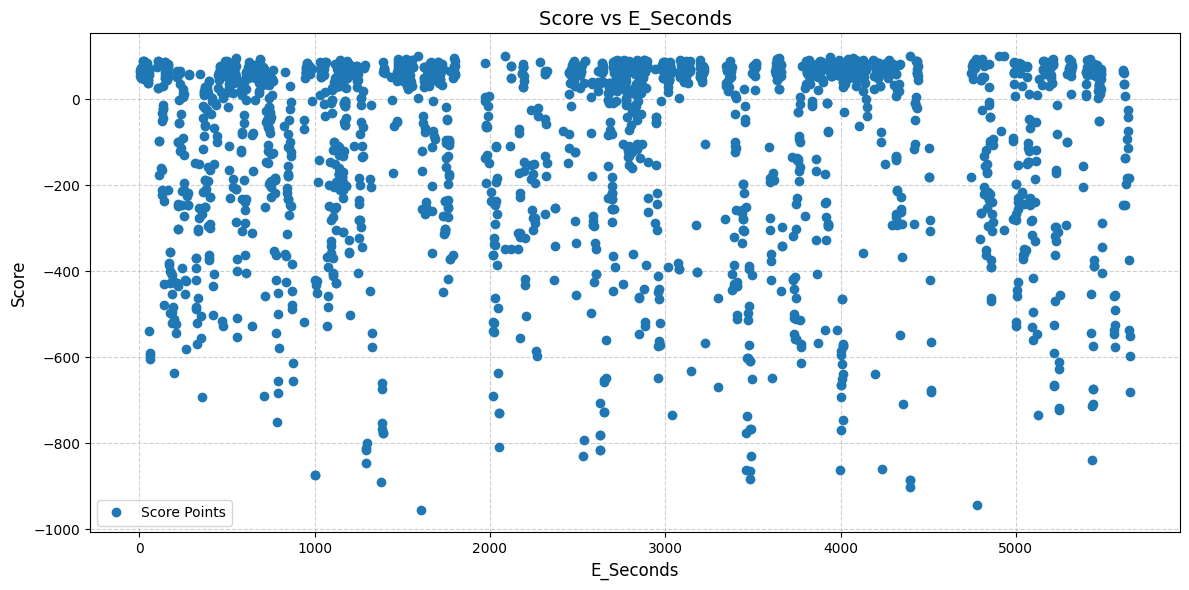

In [ ]:
import matplotlib.pyplot as plt

# 提取嵌套字典中的 'score' 值
results_df["score_value"] = results_df["score"].apply(lambda x: x["score"] if isinstance(x, dict) else None)

# 绘制图表
plt.figure(figsize=(12, 6))
plt.plot(results_df["e_seconds"], results_df["score_value"], marker='o', linestyle='None', label='Score Points')
plt.title("Score vs E_Seconds", fontsize=14)
plt.xlabel("E_Seconds", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



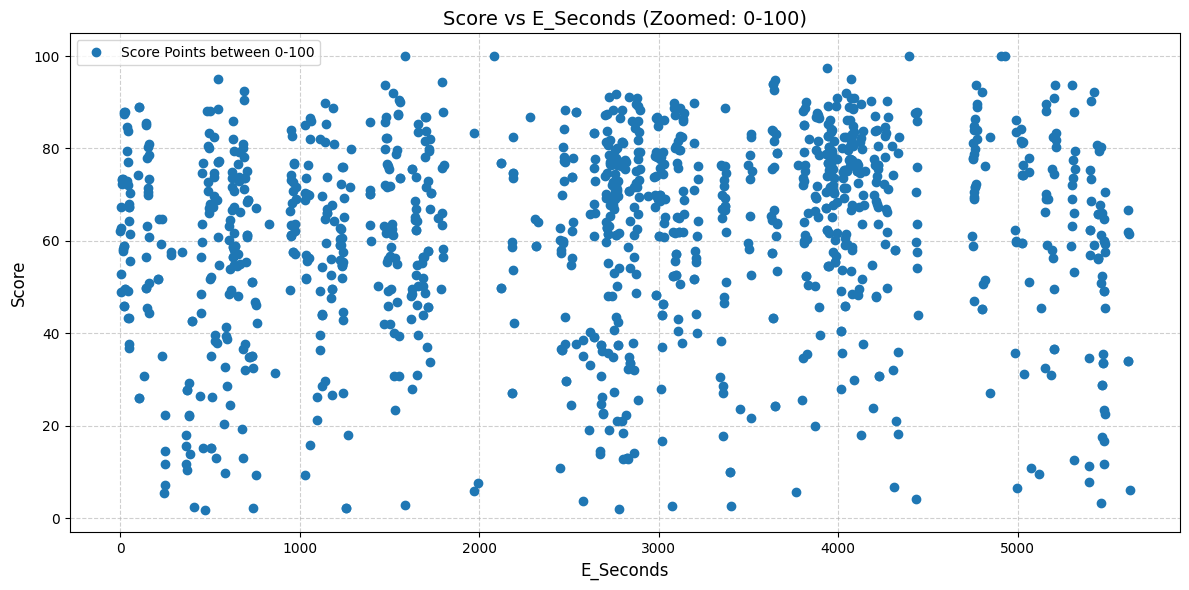

In [ ]:

# 提取嵌套字典中的 'score' 值
results_df["score_value"] = results_df["score"].apply(lambda x: x["score"] if isinstance(x, dict) else None)

# 筛选 e_seconds 在 [0, 100] 范围内的数据
filtered_df = results_df[(results_df["score_value"] >= 0)]

# 绘制图表
plt.figure(figsize=(12, 6))
plt.plot(filtered_df["e_seconds"], filtered_df["score_value"], marker='o', linestyle= "None", label='Score Points between 0-100')
plt.title("Score vs E_Seconds (Zoomed: 0-100)", fontsize=14)
plt.xlabel("E_Seconds", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 计算总数据点数量
total_count = len(results_df)
print(total_count)
# 计算分数大于 60 分的数据点数量
above_60_count = results_df[results_df["score_value"] > 60].shape[0]
print(above_60_count)
# 计算比例
proportion_above_60 = above_60_count / total_count if total_count > 0 else 0

# 显示比例
print(f"分数大于 60 分的比例: {proportion_above_60:.2%}")

2158
708
分数大于 60 分的比例: 32.81%


In [ ]:
# 筛选 score_value 大于 60 的数据
filtered_results_1 = results_df[results_df["score_value"] > 60]

# 初始化结果列表
merged_rows = []

# 遍历筛选结果
for _, row in filtered_results_1.iterrows():
    e_seconds = row["e_seconds"]
    adjusted_seconds = row["score"]["adjusted_seconds"] if isinstance(row["score"], dict) else None

    # 从 df_event 中找到 e_seconds 对应的行
    event_row = df_event[df_event["seconds"] == e_seconds]

    # 从 df_tracking 中找到 adjusted_seconds 对应的行
    tracking_row = df_tracking[df_tracking["seconds"] == adjusted_seconds]

    # 如果两者都找到，则合并
    if not event_row.empty and not tracking_row.empty:
        merged_row = {
            "e_seconds": e_seconds,
            "adjusted_seconds": adjusted_seconds,
            **event_row.iloc[0].to_dict(),  # 展开 event_row 数据
            **tracking_row.iloc[0].to_dict(),  # 展开 tracking_row 数据
        }
        merged_rows.append(merged_row)

# 转换为 DataFrame
merged_df = pd.DataFrame(merged_rows)

In [ ]:
merged_df_path = "/home/z_chen/workspace3/test/merged_df.csv"
merged_df.to_csv(merged_df_path, index=False)
print(f"merged_df saved to {merged_df_path}")


merged_df saved to /home/z_chen/workspace3/test/merged_df.csv


In [ ]:
# 需要保留的列
columns_to_keep1 = [
    "e_seconds", "adjusted_seconds", "match_id", "period", "time", "minute", "second",
    "event_type", "event_type_2", "team", "home_team", "player", "start_x", "start_y",
    "end_x", "end_y", "pass_type", "pass_height", "pass_outcome", "possession_team",
    "needs_reverse", "preprocessed_name", "normalized_name", "matched_name",
    # 所有的 h 列的 x y 和 a 列的 x y
    *[f"h{i}_x" for i in range(1, 24)], *[f"h{i}_y" for i in range(1, 24)],
    *[f"a{i}_x" for i in range(1, 24)], *[f"a{i}_y" for i in range(1, 24)],
    "home_side", "ball_x", "ball_y", "ball_z", "raw_seconds"
]
output_file = "/home/z_chen/workspace3/test/simplified_results.csv"

# 保留指定列
simplified_df = merged_df[columns_to_keep]
simplified_df.to_csv(output_file, index=False)

simplified_df.to_csv(output_file, index=False)
print(f"simplified DataFrame saved to {output_file}")



simplified DataFrame saved to /home/z_chen/workspace3/test/simplified_results.csv


In [ ]:
print(df_tracking.iloc[0:10]["adjusted_seconds"])

0   -0.3
1   -0.2
2   -0.1
3    0.0
4    0.1
5    0.2
6    0.3
7    0.4
8    0.5
9    0.6
Name: adjusted_seconds, dtype: float64


In [ ]:
# def compute_offsets(df_m):
#     df_m.loc[:, 'offset'] = round(df_m['adjusted_seconds'] - df_m['e_seconds'], 1)
#     return df_m

# def align_events(df_event11, df_tracking11, df_m):
#     df_m = compute_offsets(df_m)
#     total_offset = df_m['offset'].sum()

#     def find_weighted_offset(event_time):
#         # 计算 event_time 在 df_m['e_seconds'] 中的位置百分比
#         if df_m['e_seconds'].min() == df_m['e_seconds'].max():
#             return df_m['offset'].mean()  # 如果所有 e_seconds 相等，直接返回平均值

#         relative_position = (event_time - df_m['e_seconds'].min()) / (df_m['e_seconds'].max() - df_m['e_seconds'].min())
#         weights = 1 - abs(df_m['e_seconds'] - event_time) / (df_m['e_seconds'].max() - df_m['e_seconds'].min())
#         weighted_offset = round((weights * df_m['offset']).sum() / weights.sum(),1)
#         return weighted_offset

#     # 应用权重偏移到每个事件
#     df_event11['adjusted_seconds'] = df_event11['seconds'].apply(
#         lambda x: x + find_weighted_offset(x)
#     )

#     # 对 df_event 和 df_tracking 进行对齐
#     df_event11['adjusted_seconds_rounded'] = df_event11['adjusted_seconds'].round(1)
#     aligned_df = pd.merge(
#         df_event11,
#         df_tracking11,
#         left_on='adjusted_seconds_rounded',
#         right_on='adjusted_seconds',
#         how='left',
#         suffixes=('_event', '_tracking')
#     )

#     return aligned_df

# aligned_df = align_events(df_event, df_tracking, simplified_df)

# save_aligned = "/home/z_chen/workspace3/test/aligned_df.csv"
# aligned_df.to_csv(save_aligned, index=False)
# print(f"aligned DataFrame saved to {save_aligned}")


In [ ]:
print(max_seconds1)
df_event["adjusted_seconds"] = df_event["seconds"] - max_seconds1
print(df_event["adjusted_seconds"].min)

0.3
<bound method NDFrame._add_numeric_operations.<locals>.min of 0         -0.300
1         -0.300
2         -0.300
3         -0.300
4          0.142
          ...   
3682    5655.370
3683    5741.404
3684    5741.976
3685    5758.715
3686    5758.715
Name: adjusted_seconds, Length: 3687, dtype: float64>


In [ ]:
# def compute_offsets(df_m,df_e,df_t):
#     df_m = df_m.copy()  # 确保对原始 DataFrame 的副本操作
#     df_m.loc[:, 'offset'] = round(df_m['adjusted_seconds'] - df_m['e_seconds'], 1)
#     return df_m
def compute_offsets(df_m, df_e):
    df_m = df_m.copy()  # 确保对原始 DataFrame 的副本操作

    # 初始化偏移列
    df_m['offset'] = 0

    # 遍历 df_m 的每一段，计算分段偏移
    for i in range(len(df_m)):
        if i == 0:
            start = df_e['adjusted_seconds'].min()
        else:
            start = df_m.iloc[i - 1]['e_seconds']

        end = df_m.iloc[i]['e_seconds']
        adjusted_end = df_m.iloc[i]['adjusted_seconds']

       # 计算时间占比
        event_rows = df_e[(df_e['adjusted_seconds'] >= start) & (df_e['adjusted_seconds'] < adjusted_end)]
        if not event_rows.empty:
            time_ratio = (event_rows['adjusted_seconds'] - start) / (adjusted_end - start)
            df_e.loc[event_rows.index, 'adjusted_seconds_1'] = event_rows['adjusted_seconds'] + time_ratio * (adjusted_end- start)

    return df_m


def align_events(df_event11, df_tracking11, df_m):
    df_m = compute_offsets(df_m,df_event11)

    def apply_offset_to_events(df_event11, df_m):
        adjusted_events = []
        for i in range(len(df_m)):
            # 当前偏移区间
            if i == 0:
                start = df_event11['seconds'].min()
            else:
                start = df_m.iloc[i - 1]['e_seconds']

            end = df_m.iloc[i]['e_seconds']
            event_rows = df_event11[(df_event['seconds'] >= start) & (df_event['seconds'] < end)]
            
            # 避免除以零
            if len(event_rows) > 0:
                offset = df_m.iloc[i]['offset'] / len(event_rows)
            else:
                offset = 0

            # 调整 seconds
            df_event.loc[(df_event11['seconds'] >= start) & (df_event11['seconds'] < end), 'adjusted_seconds_1'] = \
                df_event11['adjusted_seconds'] + offset

        return df_event11

    # 应用偏移
    df_event12 = apply_offset_to_events(df_event11, df_m)

    # 对 df_event 和 df_tracking 进行对齐
    df_event12['adjusted_seconds_rounded'] = df_event12['adjusted_seconds_1'].round(1)
    aligned_df = pd.merge(
        df_event12,
        df_tracking11,
        left_on='adjusted_seconds_rounded',
        right_on='adjusted_seconds',
        how='left',
        suffixes=('_event', '_tracking')
    )

    return aligned_df

aligned_df = align_events(df_event, df_tracking, simplified_df)

save_aligned = "/home/z_chen/workspace3/test/aligned_df.csv"
aligned_df.to_csv(save_aligned, index=False)
print(f"aligned DataFrame saved to {save_aligned}")


aligned DataFrame saved to /home/z_chen/workspace3/test/aligned_df.csv


In [ ]:
def compute_offsets(df_m, df_e):
    df_m = df_m.copy()  # 确保对原始 DataFrame 的副本操作

    # 初始化偏移列
    df_m['offset'] = 0

    # 遍历 df_m 的每一段，计算分段偏移
    for i in range(len(df_m)):
        if i == 0:
            start = df_e['seconds'].min()

        else:
            start = df_m.iloc[i - 1]['e_seconds']


        end = df_m.iloc[i]['e_seconds']
        adjusted_end = df_m.iloc[i]['adjusted_seconds']


        # 计算时间占比
        event_rows = df_e[(df_e['seconds'] > start) & (df_e['seconds'] <= end)]
        if not event_rows.empty:
            time_ratio = (event_rows['seconds'] - start) / (end - start)

            df_e.loc[event_rows.index, 'adjusted_seconds_1'] = event_rows['seconds'] + time_ratio * (adjusted_end- end)
    return df_m, df_e

def align_events(df_event11, df_tracking11, df_m11):
    df_m12, df_event12 = compute_offsets(df_m11, df_event11)
    # 对 df_event 和 df_tracking 进行对齐
    df_event12['adjusted_seconds_rounded'] = df_event12['adjusted_seconds_1'].round(1)
    print(df_event12["adjusted_seconds_rounded"].iloc[5:15])
    aligned_df_1 = pd.merge(
        df_event12,
        df_tracking11,
        left_on='adjusted_seconds_rounded',
        right_on='adjusted_seconds',
        how='left',
        suffixes=('_event', '_tracking')
    )

    return aligned_df_1

aligned_df_2 = align_events(df_event, df_tracking, simplified_df)

save_aligned = "/home/z_chen/workspace3/test/aligned_df2.csv"
aligned_df_2.to_csv(save_aligned, index=False)
print(f"aligned DataFrame saved to {save_aligned}")

5      5.0
6      5.0
7      4.9
8      7.4
9      7.4
10     7.8
11     9.8
12     9.8
13     9.8
14    13.3
Name: adjusted_seconds_rounded, dtype: float64
aligned DataFrame saved to /home/z_chen/workspace3/test/aligned_df2.csv


In [ ]:
# 找到 seconds_event 的索引
seconds_event_index = aligned_df_2.columns.get_loc("seconds_event")

# 生成新的列顺序
columns3 = aligned_df_2.columns.tolist()
new_columns_order = (
    columns3[:seconds_event_index + 1] +  # 包含 seconds_event 之前的列
    ["raw_seconds", "adjusted_seconds_tracking"] +  # 插入新的列
    [col for col in columns3 if col not in {"raw_seconds", "adjusted_seconds_tracking"}]  # 排除已插入的列
)

# 重新排列列顺序
aligned_df_3 = aligned_df_2[new_columns_order]

# 保存文件
save_aligned3 = "/home/z_chen/workspace3/test/aligned_df3.csv"
aligned_df_3.to_csv(save_aligned3, index=False)
print(f"Aligned DataFrame saved to {save_aligned3}")


Aligned DataFrame saved to /home/z_chen/workspace3/test/aligned_df3.csv


In [ ]:
print(aligned_df_2.iloc[8]["adjusted_seconds_rounded"])
print(aligned_df_2.iloc[8]["seconds_event"])

7.4
6.232


In [ ]:
for row in range(10):
    # 过滤条件
    filtered_aligned_df = aligned_df_2[aligned_df_2["event_type"] == "Ball Receipt*"]
    # 使用 iloc 访问行数据
    print(filtered_aligned_df.iloc[row][["ball_x", "ball_y"]])
    print(filtered_aligned_df.iloc[row][["start_x", "start_y"]])
    print(filtered_aligned_df.iloc[row]["needs_reverse"])

ball_x    74.46
ball_y    36.36
Name: 5, dtype: object
start_x    74.37
start_y    34.09
Name: 5, dtype: object
True
ball_x    73.37
ball_y     6.38
Name: 8, dtype: object
start_x    72.8
start_y    3.15
Name: 8, dtype: object
True
ball_x    85.92
ball_y    15.45
Name: 11, dtype: object
start_x    87.32
start_y     14.2
Name: 11, dtype: object
True
ball_x     98.3
ball_y    32.96
Name: 14, dtype: object
start_x    99.49
start_y    32.64
Name: 14, dtype: object
True
ball_x    67.16
ball_y    66.72
Name: 17, dtype: object
start_x    68.69
start_y    64.43
Name: 17, dtype: object
True
ball_x    84.45
ball_y    62.22
Name: 20, dtype: object
start_x    84.17
start_y    60.94
Name: 20, dtype: object
True
ball_x    84.92
ball_y     55.0
Name: 24, dtype: object
start_x    84.61
start_y    44.88
Name: 24, dtype: object
True
ball_x    97.43
ball_y    46.15
Name: 27, dtype: object
start_x    101.41
start_y     43.35
Name: 27, dtype: object
True
ball_x    79.28
ball_y    48.69
Name: 29, dtype: obj

In [ ]:
print(aligned_df_2["pass_cluster_label"].dropna().unique())

['Defensive third - Center - To right - Short - Ground Pass'
 'Defensive third - Right - To left - Short - Ground Pass'
 'Defensive third - Right - Backwards - Short - Ground Pass'
 'Defensive third - Center - Forwards - Long - High Pass'
 'Midfield third - Left - Backwards - Short - Ground Pass'
 'Defensive third - Left - To right - Short - Ground Pass'
 'Defensive third - Center - To left - Short - Ground Pass'
 'Defensive third - Center - Forwards - Short - Ground Pass'
 'Midfield third - Center - To right - Short - Ground Pass'
 'Defensive third - Right - Forwards - Short - Ground Pass'
 'Attacking third - Left - Forwards - Short - Ground Pass'
 'Attacking third - Left - Backwards - Short - Ground Pass'
 'Midfield third - Center - Forwards - Short - Ground Pass'
 'Midfield third - Right - Backwards - Short - Ground Pass'
 'Attacking third - Center - To left - Short - Ground Pass'
 'Midfield third - Center - To left - Short - Ground Pass'
 'Attacking third - Left - To right - Short 